# Ultra Light задание.
Возьмите шаблон ноутбука и напишите по памяти сеть, построенную на предобученной сети для классификации изображений, используя альтернативный датасет из библиотеки torchvision.


In [ ]:
from torchvision import models # здесь лежат предобученные сетки

import argparse
from types import SimpleNamespace # простой класс, где можно прописать параметры
import json
import time

# Для визуализации
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
import scipy

# Библиотеки Pytorch
import torch 
import torchvision # здесь лежит mnist, cifar и много других датасетов и трансформаций для картинок
import torch.nn as nn # здесь лежат все слои
import torch.utils.data as data # работа с загрузчиком данных
import torchvision.transforms as transforms
import torchvision.datasets as dsets #работа с классом Датасет
from torch.autograd import Variable # для автоматического дифференциатора

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Пример использования предобученной модели на VGG19

In [ ]:
 # загружаем готовую предобученную сеть, переключаем в режим проверки
 vgg19 = torchvision.models.vgg19(pretrained=True).eval()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


Загружаем разметку между названием класса и соответствующему ему числу

In [ ]:
!wget https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json # подгружаем одной командой (из документации ImageNet)
class_idx = json.load(open("imagenet_class_index.json"))
idx2label = np.array([class_idx[str(k)][1] for k in range(len(class_idx))])

--2020-11-02 06:34:48--  https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.85.134
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.85.134|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35363 (35K) [application/octet-stream]
Saving to: ‘imagenet_class_index.json’

imagenet_class_inde 100%[===================>]  34.53K  --.-KB/s    in 0.07s   

2020-11-02 06:34:48 (528 KB/s) - ‘imagenet_class_index.json’ saved [35363/35363]



vgg19 была обучена на датасете imagenet, где входящие значения были нормализованы следующим образом:

In [ ]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=(0.485, 0.456, 0.406), 
                                                                            std=(0.229, 0.224, 0.225))])

In [ ]:
vgg19.classifier # выводим слой, отвечающий за классификацию

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

Посмотрим, что умеет эта сетка

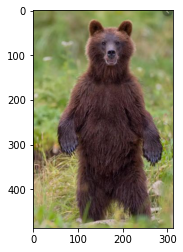

torch.Size([3, 487, 313])
Метка класса: brown_bear - Вероятность: 0.924632
Метка класса: American_black_bear - Вероятность: 0.061372
Метка класса: sloth_bear - Вероятность: 0.008378
Метка класса: groenendael - Вероятность: 0.001433
Метка класса: lesser_panda - Вероятность: 0.000327


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


In [ ]:
# Загружаем картинку
path = '/content/bear.JPG'
im_org = Image.open(path)

# Покажем картинку
plt.imshow(im_org)
plt.show()

# Применяем нормализацию
im = transform(im_org)
print(im.shape)

#Пропустим через софтмакс выход с последнего слоя предобученной сети, через которую мы прогнали наше изображение
probas = nn.Softmax()(vgg19(im.unsqueeze(0))).view(-1) # добавляем дополнительное измерение,
                                                       # чтобы получить тензор формата [размер batch, ширина, высота, количество каналов]
                                                       # и вытягиваем в вектор
                                                       
sortedOuputs = torch.argsort(probas, descending=True) # в соответствие с каждой вероятностью подбираем класс

# Вывод 5 наиболее вероятных классов
for i in range(5):
    print("Метка класса: {:s} - Вероятность: {:4f}".format(
        idx2label[sortedOuputs[i]], probas[sortedOuputs[i]]))

## Настройка (Fine-tuning) предобученной модели на CIFAR100

Точность распознания 36%

Загрузим выбранный датасет

In [ ]:
batchSize = 200
numClasses = 100
numEpochs = 10
learningRate = 0.00001

trainDataset = dsets.CIFAR100(root='./data', 
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=True) # Загружаем обучающую выборку CIFAR10

testDataset = dsets.CIFAR100(root='./data', 
                           train=False, 
                           transform=transforms.ToTensor()) # Загружаем тестовую выборку CIFAR10

trainLoader = torch.utils.data.DataLoader(dataset=trainDataset, 
                                           batch_size=batchSize, 
                                           shuffle=True) # Создаем загрузчик для обучающей выборки

testLoader = torch.utils.data.DataLoader(dataset=testDataset, 
                                          batch_size=batchSize, 
                                          shuffle=False) # Создаем загрузчик для тестовой выборки

Extracting ./data/cifar-100-python.tar.gz to ./data


In [ ]:
iterator = iter(trainLoader)    
samples, labels = iterator.next()

In [ ]:
# Узнаем, с каким размером мы работаем на avgpool, чтоб ввести правильные параметры слоя
print(samples.shape)
print(vgg19.avgpool(vgg19.features(samples)).shape)

torch.Size([200, 3, 32, 32])
torch.Size([200, 512, 7, 7])


In [ ]:
# Заморозим веса всей сети
for param in vgg19.parameters(): # поскольку мы будем тренировать под наш сет только последний слой
    param.requires_grad = False

In [ ]:
# Заменим последний слой для настройки под наш датасет
vgg19.classifier = nn.Linear(25088, 100) # 25088 = 7*7*512 - в качестве входных нейронов подаем результат вытягивания того, что на AveragePooling2D(avgpool)
                                        # на выходе 100 нейронов, т.к. 100 классов

In [ ]:
# Функция ошибки
criterion = nn.CrossEntropyLoss()
# Оптимизатор
optimizer = torch.optim.Adam(vgg19.classifier.parameters(), lr=learningRate)
# Обучим наш последний слой
for epoch in range(numEpochs):
    for i, (images, labels) in enumerate(trainLoader):        
        optimizer.zero_grad() # обнуляем градиенты
        outputs = vgg19(images) # подаем наше изображение на вход
        loss = criterion(outputs, labels) # считаем ошибку
        loss.backward() # берем производную
        optimizer.step() # делаем шаг оптимизатором
        
        if (i+1) % 1 == 0:
            print('Эпоха: [%d/%d], Шаг: [%d/%d], Потеря: %.4f' 
                  % (epoch+1, numEpochs, i+1, len(trainDataset)//batchSize, loss))
# Сохраним полученные веса
torch.save(vgg19, '/content/drive/My Drive/Colab Notebooks/Веса и архитектуры сетей/vgg19.pkl')

Эпоха: [1/10], Шаг: [1/250], Потеря: 4.6471
Эпоха: [1/10], Шаг: [2/250], Потеря: 4.6826
Эпоха: [1/10], Шаг: [3/250], Потеря: 4.6624
Эпоха: [1/10], Шаг: [4/250], Потеря: 4.6652
Эпоха: [1/10], Шаг: [5/250], Потеря: 4.5760
Эпоха: [1/10], Шаг: [6/250], Потеря: 4.6144
Эпоха: [1/10], Шаг: [7/250], Потеря: 4.5642
Эпоха: [1/10], Шаг: [8/250], Потеря: 4.5779
Эпоха: [1/10], Шаг: [9/250], Потеря: 4.5625
Эпоха: [1/10], Шаг: [10/250], Потеря: 4.5525
Эпоха: [1/10], Шаг: [11/250], Потеря: 4.5205
Эпоха: [1/10], Шаг: [12/250], Потеря: 4.4759
Эпоха: [1/10], Шаг: [13/250], Потеря: 4.4386
Эпоха: [1/10], Шаг: [14/250], Потеря: 4.4136
Эпоха: [1/10], Шаг: [15/250], Потеря: 4.4522
Эпоха: [1/10], Шаг: [16/250], Потеря: 4.4605
Эпоха: [1/10], Шаг: [17/250], Потеря: 4.3743
Эпоха: [1/10], Шаг: [18/250], Потеря: 4.4468
Эпоха: [1/10], Шаг: [19/250], Потеря: 4.3742
Эпоха: [1/10], Шаг: [20/250], Потеря: 4.3853
Эпоха: [1/10], Шаг: [21/250], Потеря: 4.3425
Эпоха: [1/10], Шаг: [22/250], Потеря: 4.3608
Эпоха: [1/10], Шаг:

FileNotFoundError: ignored

In [ ]:
# vgg19 = torch.load('/content/drive/My Drive/Colab Notebooks/Веса и архитектуры сетей/vgg19.pkl')

In [ ]:
# включаем режим проверки
vgg19.eval()
# проверим результат сети
curTime = time.time()
correct = 0
total = 0

for images, labels in testLoader: # проходимся по всему тестовому загрузчику
    outputs = vgg19(images) # классифицируем
    _, predicted = torch.max(outputs.data, 1) # вытаскиваем индексы лейблов
    total += labels.size(0) # здесь лежит количество всего
    correct += (predicted == labels).sum() # считаем количество совпадений
    
print('Точность для 10000 картинок: %d %%' % (100 * correct.item() / total))
print('time: ', time.time()-curTime)

Точность для 10000 картинок: 36 %
time:  140.99628329277039


In [ ]:
# посмотрите на размер картинки
images[0].shape

torch.Size([3, 32, 32])

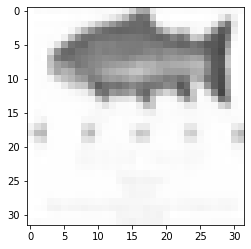

Факт: tensor(91)
Предсказание: tensor(91)


In [ ]:
n = 0
im = images[n,1].numpy() # Превращаем картинку в массив
im = 255*np.reshape(im,(32,32)) # Приводим к формату RGB
x = Image.fromarray(im.astype(np.uint8)).convert('RGBA') #Данные массива должны быть универсальной кодировки и приводим к формату изображения

plt.imshow(x)
plt.show()

# Предсказание
print('Факт:', labels[n])
print("Предсказание:", predicted[n])

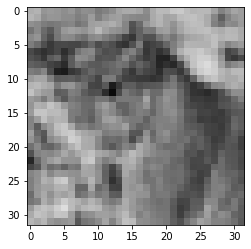

Факт: tensor(80)
Предсказание: tensor(97)


In [ ]:
n = 10
im = images[n,1].numpy() # Превращаем картинку в массив
im = 255*np.reshape(im,(32,32)) # Приводим к формату RGB
x = Image.fromarray(im.astype(np.uint8)).convert('RGBA') #Данные массива должны быть универсальной кодировки и приводим к формату изображения

plt.imshow(x)
plt.show()

# Предсказание
print('Факт:', labels[n])
print("Предсказание:", predicted[n])

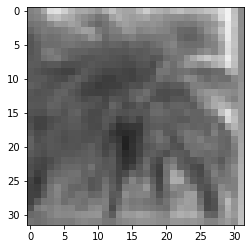

Факт: tensor(56)
Предсказание: tensor(56)


In [ ]:
n = 150
im = images[n,1].numpy() # Превращаем картинку в массив
im = 255*np.reshape(im,(32,32)) # Приводим к формату RGB
x = Image.fromarray(im.astype(np.uint8)).convert('RGBA') #Данные массива должны быть универсальной кодировки и приводим к формату изображения

plt.imshow(x)
plt.show()

# Предсказание
print('Факт:', labels[n])
print("Предсказание:", predicted[n])